In [3]:
###########################################################
#Title: Daily sale prediction using machine learning     ##
#Author: Pair Phongphaew, Salma EL HASSANI, Michael Zhou ##
#Date : Feb 14, 2023                                     ##
###########################################################

In [4]:
import pandas as pd 
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime as dt   # To access datetime 
from pandas import Series        # To work on series 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
xls = pd.ExcelFile('online_retail_II.xlsx')
df1 = pd.read_excel(xls, 'Year 2009-2010')
df2 = pd.read_excel(xls, 'Year 2010-2011')

In [6]:
print(df1.keys())
print(df2.keys())

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [7]:
#Find the country that has the most transactions 
group_country_df1 = df1.groupby("Country").count().sort_values(by=['Invoice'],ascending=False)
group_country_df2 = df2.groupby("Country").count().sort_values(by=['Invoice'],ascending=False)
print(group_country_df1.head())
print(group_country_df2.head())

                Invoice  StockCode  Description  Quantity  InvoiceDate  \
Country                                                                  
United Kingdom   485852     485852       482924    485852       485852   
EIRE               9670       9670         9670      9670         9670   
Germany            8129       8129         8129      8129         8129   
France             5772       5772         5772      5772         5772   
Netherlands        2769       2769         2769      2769         2769   

                 Price  Customer ID  
Country                              
United Kingdom  485852       379423  
EIRE              9670         8710  
Germany           8129         8129  
France            5772         5710  
Netherlands       2769         2769  
                Invoice  StockCode  Description  Quantity  InvoiceDate  \
Country                                                                  
United Kingdom   495478     495478       494024    495478       495

Comment: the data in the France is big enough to forcast so we are going to focus on the sales throughout the years in this country 

In [8]:
d_France1 = df1[df1['Country'] == 'France']
d_France2 = df2[df2['Country'] == 'France']
#calculate Total = Quantity*Price (total sales)
d_France1_new = d_France1.copy() 
d_France2_new = d_France2.copy() 
d_France1_new["total"] = d_France1["Quantity"]*d_France1["Price"]
d_France2_new["total"] = d_France2["Quantity"]*d_France2["Price"]
#now drop unneccessay columns 
d_France1_new = d_France1_new.drop(['Invoice','Country','Description','Price','Quantity','Customer ID'],axis =1).dropna(axis=0)
d_France2_new = d_France2_new.drop(['Invoice','Country','Description','Price','Quantity','Customer ID'],axis =1).dropna(axis=0)

In [9]:
#concat d_France1 and d_France2 
frames = [d_France1_new,d_France2_new]
d_all = pd.concat(frames,ignore_index=True) #Year 2009 to 2011 
#print(d_all.tail(5))
# InvoiceDate to date only
d_all['InvoiceDate'] = pd.to_datetime(d_all.InvoiceDate)
#print(d_all)

#extract the Year-Month-Day-Hour 
d_all['Year'] = d_all.InvoiceDate.dt.year
d_all['Month'] = d_all.InvoiceDate.dt.month
d_all['Day'] = d_all.InvoiceDate.dt.day
d_all['Hour'] = d_all.InvoiceDate.dt.hour

After looking at the data, we are going to predict the daily sales in United Kingdom

### EDA

Hypothesis
1. the avg sales will be high during the end of the year
2. Sale is high around the beginning of the month

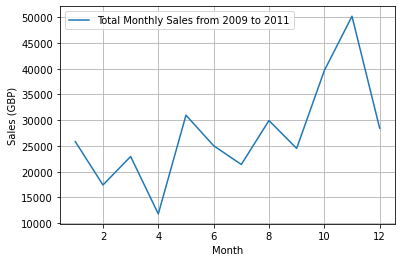

In [10]:
sales_per_month = d_all.groupby('Month')['total'].sum()
plt.plot(sales_per_month)
plt.ylabel('Sales (GBP)')
plt.xlabel('Month')
plt.legend(['Total Monthly Sales from 2009 to 2011'])
plt.grid(True)

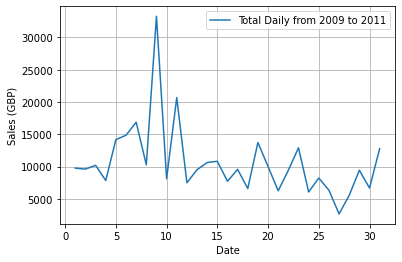

In [11]:
sales_per_day = d_all.groupby('Day')['total'].sum()
plt.plot(sales_per_day) 
plt.ylabel('Sales (GBP)')
plt.xlabel('Date')
plt.legend(['Total Daily from 2009 to 2011'])
plt.grid(True)

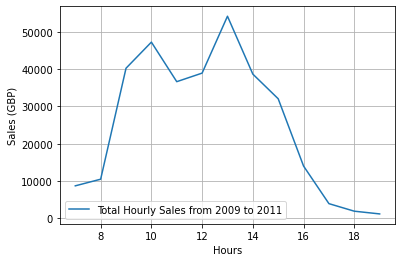

In [12]:
sales_per_hour = d_all.groupby('Hour')['total'].sum()
plt.plot(sales_per_hour) 
plt.ylabel('Sales (GBP)')
plt.xlabel('Hours')
plt.legend(['Total Hourly Sales from 2009 to 2011'])
plt.grid(True)

Spliting data for training, validation, and testing

In [13]:
#print(d_all)
X = d_all.copy()
X = X.set_index('InvoiceDate')
#X = X.drop(['StockCode','Year','Month','Day','Hour'],axis =1)
print(X)

                    StockCode  total  Year  Month  Day  Hour
InvoiceDate                                                 
2009-12-01 09:28:00     22065  17.40  2009     12    1     9
2009-12-01 09:28:00     22138  44.55  2009     12    1     9
2009-12-01 09:28:00     22139  44.55  2009     12    1     9
2009-12-01 09:28:00     22352  30.60  2009     12    1     9
2009-12-01 09:28:00    85014A  17.85  2009     12    1     9
...                       ...    ...   ...    ...  ...   ...
2011-12-09 12:50:00     22899  12.60  2011     12    9    12
2011-12-09 12:50:00     23254  16.60  2011     12    9    12
2011-12-09 12:50:00     23255  16.60  2011     12    9    12
2011-12-09 12:50:00     22138  14.85  2011     12    9    12
2011-12-09 12:50:00      POST  18.00  2011     12    9    12

[14330 rows x 6 columns]


Resample the total sales by day and drop the day that has zero sale

In [14]:
#resample TOTAL OF THE SAME YEAR-MONTH-DAY
temp = X.total.resample('D').sum()
daily_resampled=temp.to_frame('total')
#print(daily_resampled[daily_resampled['total']==0])
daily_resampled.drop(daily_resampled.loc[daily_resampled['total']==0].index, inplace=True)

               total
InvoiceDate         
2009-12-01   1024.29
2009-12-02    549.33
2009-12-03   -143.90
2009-12-04    636.90
2009-12-06    817.44
...              ...
2011-12-05    797.48
2011-12-06   1403.94
2011-12-07   1117.62
2011-12-08    146.70
2011-12-09    267.45

[371 rows x 1 columns]


Text(0, 0.5, 'total sales (GBP)')

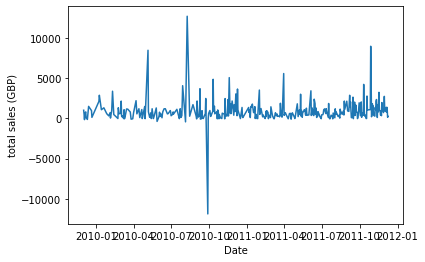

In [15]:
print(daily_resampled)

plt.plot(daily_resampled)
plt.xlabel('Date')
plt.ylabel('total sales (GBP)')

In [16]:
from sklearn.metrics import mean_absolute_percentage_error

In [65]:
# extract the seasonality data
months = [x.month for x in daily_resampled.index]
years = [x.year for x in daily_resampled.index]
day = [x.day for x in daily_resampled.index]

# convert into one matrix
X = np.array([day, months, years]).T
y = daily_resampled.total.values

X_train, y_train = X[:260],y[:260]
X_val, y_val = X[260:314], y[260:314]                                                                        
X_test, y_test = X[314:],y[314:]

After we resampled by day, we have 371 samples and the roughly 70% of samples are going to be our training data. The next 10% will be our validation data, and the remaining 20% will be our test data. 

In [66]:
from datetime import datetime
import time
def x_to_datetime(x):
    date = []
    for i in range(len(x)):
        day = x[i][0]
        month = x[i][1]
        year = x[i][2]
        time_obj = datetime(year,month,day)
        date_str = time_obj.strftime("%Y-%m-%d")
        date.append(date_str)
    return date

In [67]:
X_train_axis = pd.DataFrame(x_to_datetime(X_train)).set_index(0)
X_val_axis = pd.DataFrame(x_to_datetime(X_val)).set_index(0)
X_test_axis = pd.DataFrame(x_to_datetime(X_test)).set_index(0)

### Linear Regression

Training set

In [68]:
from sklearn.linear_model import LinearRegression

my_lr = LinearRegression()
my_lr.fit(X_train, y_train)

# predict on the same period
preds = my_lr.predict(X_train)
mape = mean_absolute_percentage_error(y_train,preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 8.299880494687459


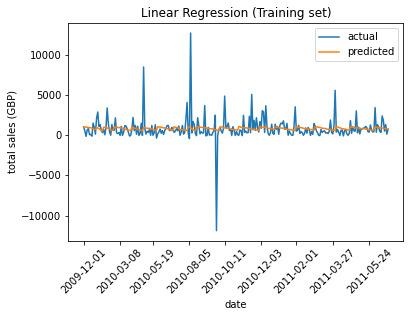

In [69]:
import matplotlib.dates as mdates
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train,label='actual')
ax.plot(X_train_axis.index,preds,label='predicted')
ax.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title("Linear Regression (Training set)")
plt.show()

Validation set

In [70]:
#val set 
# predict on the same period
val_preds = my_lr.predict(X_val)
mape = mean_absolute_percentage_error(y_val,val_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 3.309751471701615


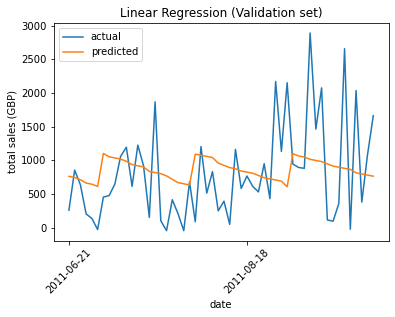

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_val_axis.index,y_val,label='actual')
ax.plot(X_val_axis.index,val_preds,label='predicted')
ax.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title("Linear Regression (Validation set)")
plt.show()

Test set

In [72]:
#test set 
# predict on the same period
test_preds = my_lr.predict(X_test)
mape = mean_absolute_percentage_error(y_test,test_preds)
print('mean absolute percentage error total:',mape)

mean absolute percentage error total: 13.441580790825215


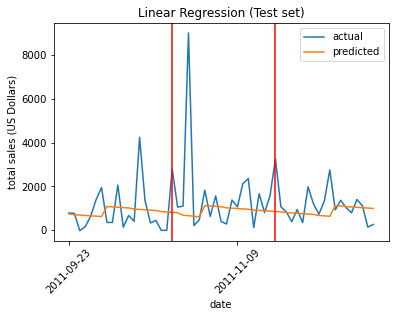

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test,label='actual')
ax.plot(X_test_axis.index,test_preds,label='predicted')
ax.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (US Dollars)")
plt.title("Linear Regression (Test set)")
plt.axvline(x = 19, color = 'r', label = '19 days')
plt.axvline(x = 38, color = 'r', label = '38 days')
plt.show()

Split test data into 3 equal-sized segments:

In [74]:
test_preds_1 = my_lr.predict(X_test[:19])
mape1 = mean_absolute_percentage_error(y_test[:19], test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_lr.predict(X_test[19:38])
mape2 = mean_absolute_percentage_error(y_test[19:38], test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_lr.predict(X_test[38:])
mape3 = mean_absolute_percentage_error(y_test[38:], test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 38.501774018611705
mean absolute percentage error (2nd third) 1.0083408958602986
mean absolute percentage error (3rd third) 0.8146274580036422
mean absolute percentage error combined: 13.441580790825215


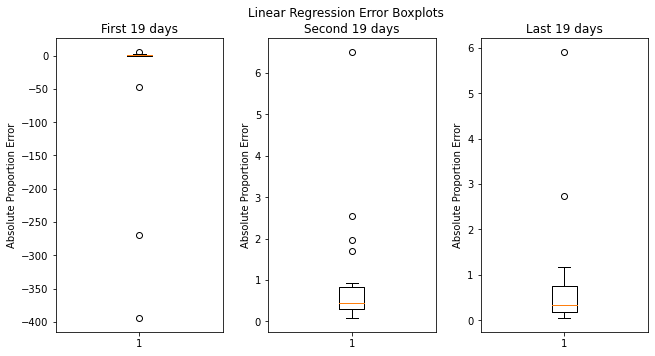

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5))
fig.suptitle('Linear Regression Error Boxplots')
fig.tight_layout()

test_ape_1 = abs(y_test[:19] - test_preds_1) / y_test[:19]
test_ape_2 = abs(y_test[19:38] - test_preds_2) / y_test[19:38]
test_ape_3 = abs(y_test[38:] - test_preds_3) / y_test[38:]

axs[0].boxplot(test_ape_1)
axs[0].set_title('First 19 days')
axs[1].boxplot(test_ape_2)
axs[1].set_title('Second 19 days')
axs[2].boxplot(test_ape_3)
axs[2].set_title('Last 19 days')

plt.setp(axs, ylabel='Absolute Proportion Error')

plt.show()

Inspect outliers:

In [76]:
# 1st segment
Q1 = np.percentile(test_ape_1, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_1, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_1 = np.array(test_ape_1 >= upper)

print(y_test[:19][upper_array_1])
print(test_preds_1[upper_array_1])

for row in X_test[:19][upper_array_1]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[145.2]
[1035.63039612]
10/6/2011


In [77]:
# 2nd segment
Q1 = np.percentile(test_ape_2, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_2, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_2 = np.array(test_ape_2 >= upper)

print(y_test[19:38][upper_array_2])
print(test_preds_2[upper_array_2])

for row in X_test[19:38][upper_array_2]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[ 809.22 1575.28]
[891.58034648 874.88244981]
11/15/2011
11/16/2011


In [78]:
# 3rd segment
Q1 = np.percentile(test_ape_3, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_3, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_3 = np.array(test_ape_3 >= upper)

print(y_test[38:][upper_array_3])
print(test_preds_3[upper_array_3])

for row in X_test[38:][upper_array_3]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[146.7  267.45]
[1014.69664349  997.99874683]
12/8/2011
12/9/2011


Remove outliers & recalculate test MAPEs:

In [79]:
X_test_1_new = X_test[:19][~upper_array_1]
y_test_1_new = y_test[:19][~upper_array_1]
test_preds_1_new = test_preds_1[~upper_array_1]

In [80]:
X_test_2_new = X_test[19:38][~upper_array_2]
y_test_2_new = y_test[19:38][~upper_array_2]
test_preds_2_new = test_preds_2[~upper_array_2]

In [81]:
X_test_3_new = X_test[38:][~upper_array_3]
y_test_3_new = y_test[38:][~upper_array_3]
test_preds_3_new = test_preds_3[~upper_array_3]

In [83]:
test_preds_1 = my_lr.predict(X_test_1_new)
mape1 = mean_absolute_percentage_error(y_test_1_new, test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_lr.predict(X_test_2_new)
mape2 = mean_absolute_percentage_error(y_test_2_new, test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_lr.predict(X_test_3_new)
mape3 = mean_absolute_percentage_error(y_test_3_new, test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 40.30007031161082
mean absolute percentage error (2nd third) 0.4295966889930126
mean absolute percentage error (3rd third) 0.40173962235039956
mean absolute percentage error combined: 13.710468874318076


The LR model gives a incommensurately high test MAPE for the first time segment, but for the second and third time segments, it gives a low MAPE. Moreoever, the IQR for the first segment is incommensurately tight, unlike the second and third time segments. This is mostly because the model predicts troughs (rather than peaks, which is the ground truth). We still need to inspect why this is the case. 

Linear Regression is have some limitation to this data so the model has low learning ability

### Random Forest Regressor

In [91]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [40, 80, 120, 160, 200]
}

best_estimator = None
min_error = 100000

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        my_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        my_rf.fit(X_train, y_train)
        
        rf_preds_val = my_rf.predict(X_val)
        mape = mean_absolute_percentage_error(y_val,rf_preds_val)
        
        if mape < min_error:
            min_error = mape
            best_estimator = my_rf
        
print(best_estimator)

RandomForestRegressor(max_depth=40, n_estimators=200, random_state=0)


Params selected from https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/ 

Training set

In [92]:
# fit the model
my_rf = best_estimator
my_rf.fit(X_train, y_train)

# predict on the same period
rf_preds = my_rf.predict(X_train)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_train,rf_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 2.9466603365686708


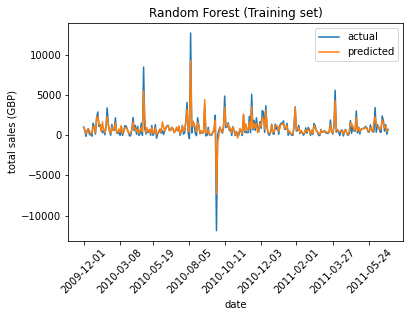

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train,label='actual')
ax.plot(X_train_axis.index,rf_preds,label='predicted')
ax.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('Random Forest (Training set)')
plt.show()

Validation set

In [94]:
# predict on the same period
val_rf_preds = my_rf.predict(X_val)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_val,val_rf_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 4.407108593991042


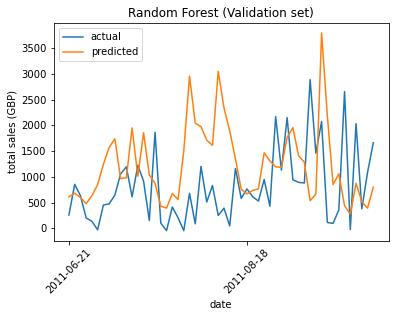

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_val_axis.index,y_val,label='actual')
ax.plot(X_val_axis.index,val_rf_preds,label='predicted')
ax.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('Random Forest (Validation set)')
plt.show()

Test set

In [96]:
# predict on the same period
test_rf_preds = my_rf.predict(X_test)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_test,test_rf_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 14.12515516140692


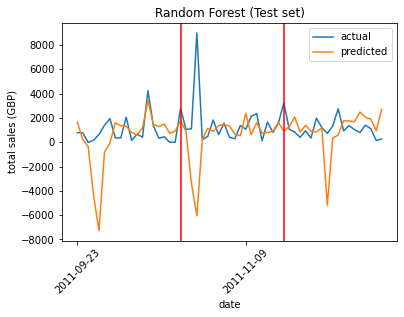

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test,label='actual')
ax.plot(X_test_axis.index,test_rf_preds,label='predicted')
ax.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('Random Forest (Test set)')
plt.axvline(x = 19, color = 'r', label = '19 days')
plt.axvline(x = 38, color = 'r', label = '38 days')
plt.show()

Split test data into 3 equal-sized segments:

In [99]:
test_preds_1 = my_rf.predict(X_test[:19])
mape1 = mean_absolute_percentage_error(y_test[:19], test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_rf.predict(X_test[19:38])
mape2 = mean_absolute_percentage_error(y_test[19:38], test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_rf.predict(X_test[38:])
mape3 = mean_absolute_percentage_error(y_test[38:], test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 39.359257517836305
mean absolute percentage error (2nd third) 1.1512473399499485
mean absolute percentage error (3rd third) 1.8649606264345089
mean absolute percentage error combined: 14.125155161406921


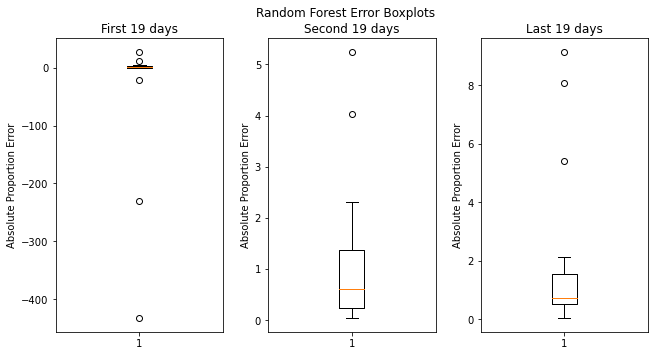

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5))
fig.suptitle('Random Forest Error Boxplots')
fig.tight_layout()

test_ape_1 = abs(y_test[:19] - test_preds_1) / y_test[:19]
test_ape_2 = abs(y_test[19:38] - test_preds_2) / y_test[19:38]
test_ape_3 = abs(y_test[38:] - test_preds_3) / y_test[38:]

axs[0].boxplot(test_ape_1)
axs[0].set_title('First 19 days')
axs[1].boxplot(test_ape_2)
axs[1].set_title('Second 19 days')
axs[2].boxplot(test_ape_3)
axs[2].set_title('Last 19 days')

plt.setp(axs, ylabel='Absolute Proportion Error')

plt.show()

Inspect outliers:

In [103]:
# 1st segment
Q1 = np.percentile(test_ape_1, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_1, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_1 = np.array(test_ape_1 >= upper)

print(y_test[:19][upper_array_1])
print(test_preds_1[upper_array_1])

for row in X_test[:19][upper_array_1]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[164.05 644.75]
[-4402.4789  -7273.74015]
9/27/2011
9/28/2011


In [104]:
# 2nd segment
Q1 = np.percentile(test_ape_2, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_2, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_2 = np.array(test_ape_2 >= upper)

print(y_test[19:38][upper_array_2])
print(test_preds_2[upper_array_2])

for row in X_test[19:38][upper_array_2]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[1103.79  123.08]
[-3352.6505   769.6041]
10/27/2011
11/13/2011


In [105]:
# 3rd segment
Q1 = np.percentile(test_ape_3, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_3, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_3 = np.array(test_ape_3 >= upper)

print(y_test[38:][upper_array_3])
print(test_preds_3[upper_array_3])

for row in X_test[38:][upper_array_3]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[733.27 146.7  267.45]
[-5184.8155    941.30945  2716.76105]
11/28/2011
12/8/2011
12/9/2011


Remove outliers & recalculate test MAPEs:

In [107]:
X_test_1_new = X_test[:19][~upper_array_1]
y_test_1_new = y_test[:19][~upper_array_1]
test_preds_1_new = test_preds_1[~upper_array_1]

In [108]:
X_test_2_new = X_test[19:38][~upper_array_2]
y_test_2_new = y_test[19:38][~upper_array_2]
test_preds_2_new = test_preds_2[~upper_array_2]

In [109]:
X_test_3_new = X_test[38:][~upper_array_3]
y_test_3_new = y_test[38:][~upper_array_3]
test_preds_3_new = test_preds_3[~upper_array_3]

In [110]:
test_preds_1 = my_rf.predict(X_test_1_new)
mape1 = mean_absolute_percentage_error(y_test_1_new, test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_rf.predict(X_test_2_new)
mape2 = mean_absolute_percentage_error(y_test_2_new, test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_rf.predict(X_test_3_new)
mape3 = mean_absolute_percentage_error(y_test_3_new, test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 41.62989422878133
mean absolute percentage error (2nd third) 0.7402013880771591
mean absolute percentage error (3rd third) 0.7993039280867889
mean absolute percentage error combined: 14.389799848315093


Like the LR model, the RF model gives a incommensurately high test MAPE for the first time segment, but for the second and third time segments, it gives a low MAPE. Moreoever, the IQR for the first segment is incommensurately tight, unlike the second and third time segments. This is mostly because the model predicts troughs (rather than peaks, which is the ground truth). We still need to inspect why this is the case. 

### XGBoost

In [464]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [111]:
import xgboost as xgb

param_grid = {
    'max_depth': np.arange(3, 11),
    'n_estimators': 100 * np.arange(11),
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'colsample_bytree': 0.1 * np.arange(5, 11),
    'subsample': 0.1 * np.arange(6, 11)
}

# set random seed
np.random.seed(0)

best_estimator = None
min_error = 100000

# random search
for _ in range(500):
    max_depth = np.random.choice(param_grid['max_depth'], )
    n_estimators = np.random.choice(param_grid['n_estimators'])
    learning_rate = np.random.choice(param_grid['learning_rate'])
    colsample_bytree = np.random.choice(param_grid['colsample_bytree'])
    subsample = np.random.choice(param_grid['subsample'])
    
    my_xgb = xgb.XGBRegressor(max_depth = max_depth, n_estimators=n_estimators, learning_rate=learning_rate, colsample_bytree=colsample_bytree, subsample=subsample, random_state=0)
    my_xgb.fit(X_train,y_train)

    xgb_preds_val = my_xgb.predict(X_val)
    mape = mean_absolute_percentage_error(y_val,xgb_preds_val)

    if mape < min_error:
        min_error = mape
        best_estimator = my_xgb
    
    
# # Grid search 
# for max_depth in param_grid['max_depth']:
#     for n_estimators in param_grid['n_estimators']:
#         for learning_rate in param_grid['learning_rate']:
#             for colsample_bytree in param_grid['colsample_bytree']:
#                 for subsample in param_grid['subsample']:
#                     my_xgb = xgb.XGBRegressor(max_depth = max_depth, n_estimators=n_estimators, learning_rate=learning_rate, colsample_bytree=colsample_bytree, subsample=subsample, random_state=0)
#                     my_xgb.fit(X_train,y_train)

#                     xgb_preds_val = my_xgb.predict(X_val)
#                     mape = mean_absolute_percentage_error(y_val,xgb_preds_val)

#                     if mape < min_error:
#                         min_error = mape
#                         best_estimator = my_xgb
            
print(best_estimator)                   

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=0, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='auto', validate_parameters=1, verbosity=None)


Params selected from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

Training set:

In [112]:
# fit the model
my_xgb = best_estimator
my_xgb.fit(X_train,y_train)

# predict on the same period
xg_preds = my_xgb.predict(X_train)

#mae
mape = mean_absolute_percentage_error(y_train,xg_preds)
print('mean absolute percentage error:',mape)


mean absolute percentage error: 1.0022588518510593


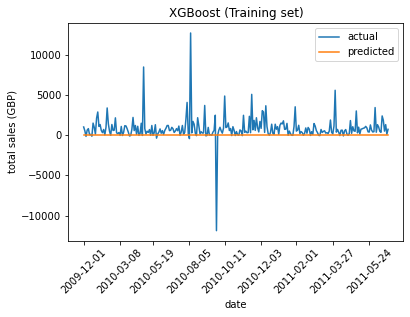

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train,label='actual')
ax.plot(X_train_axis.index,xg_preds,label='predicted')
ax.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('XGBoost (Training set)')
plt.show()

Validation set:

In [114]:
# predict on the same period
val_xg_preds = my_xgb.predict(X_val)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_val,val_xg_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.9997286611688758


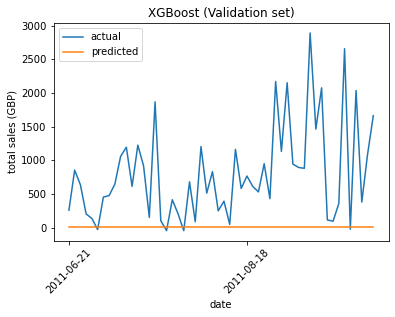

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_val_axis.index,y_val,label='actual')
ax.plot(X_val_axis.index,val_xg_preds,label='predicted')
ax.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('XGBoost (Validation set)')
plt.show()

Test set:

In [116]:
# predict on the same period
test_xg_preds = my_xgb.predict(X_test)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_test,test_xg_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 1.0066461152588413


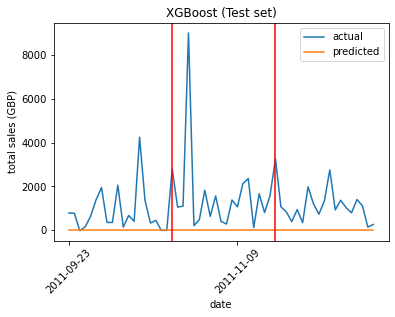

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test,label='actual')
ax.plot(X_test_axis.index,test_xg_preds,label='predicted')
ax.legend()

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('XGBoost (Test set)')
plt.axvline(x = 19, color = 'r', label = '19 days')
plt.axvline(x = 38, color = 'r', label = '38 days')
plt.show()

Split test data into 3 equal-sized segments:

In [118]:
test_preds_1 = my_xgb.predict(X_test[:19])
mape1 = mean_absolute_percentage_error(y_test[:19], test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_xgb.predict(X_test[19:38])
mape2 = mean_absolute_percentage_error(y_test[19:38], test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_xgb.predict(X_test[38:])
mape3 = mean_absolute_percentage_error(y_test[38:], test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 1.0215117991426568
mean absolute percentage error (2nd third) 0.9991863547429528
mean absolute percentage error (3rd third) 0.9992401918909138
mean absolute percentage error combined: 1.006646115258841


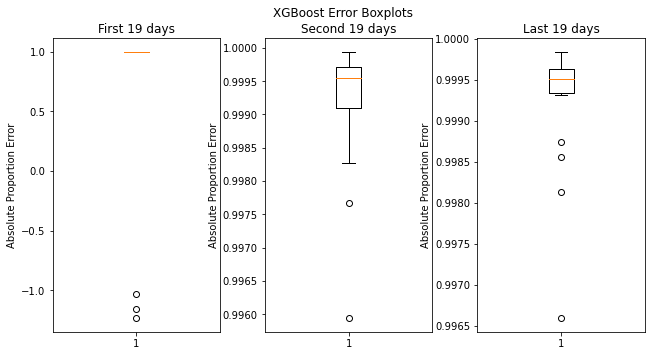

In [119]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5))
fig.suptitle('XGBoost Error Boxplots')
fig.tight_layout()

test_ape_1 = abs(y_test[:19] - test_preds_1) / y_test[:19]
test_ape_2 = abs(y_test[19:38] - test_preds_2) / y_test[19:38]
test_ape_3 = abs(y_test[38:] - test_preds_3) / y_test[38:]

axs[0].boxplot(test_ape_1)
axs[0].set_title('First 19 days')
axs[1].boxplot(test_ape_2)
axs[1].set_title('Second 19 days')
axs[2].boxplot(test_ape_3)
axs[2].set_title('Last 19 days')

plt.setp(axs, ylabel='Absolute Proportion Error')

plt.show()

Inspect outliers:

In [120]:
# 1st segment
Q1 = np.percentile(test_ape_1, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_1, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_1 = np.array(test_ape_1 >= upper)

print(y_test[:19][upper_array_1])
print(test_preds_1[upper_array_1])

for row in X_test[:19][upper_array_1]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[]
[]


In [121]:
# 2nd segment
Q1 = np.percentile(test_ape_2, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_2, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_2 = np.array(test_ape_2 >= upper)

print(y_test[19:38][upper_array_2])
print(test_preds_2[upper_array_2])

for row in X_test[19:38][upper_array_2]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[]
[]


In [122]:
# 3rd segment
Q1 = np.percentile(test_ape_3, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(test_ape_3, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above upper bound
upper=Q3+1.5*IQR
upper_array_3 = np.array(test_ape_3 >= upper)

print(y_test[38:][upper_array_3])
print(test_preds_3[upper_array_3])

for row in X_test[38:][upper_array_3]:
    print(f'{row[1]}/{row[0]}/{row[2]}')

[]
[]


Remove outliers & recalculate test MAPEs:

In [123]:
X_test_1_new = X_test[:19][~upper_array_1]
y_test_1_new = y_test[:19][~upper_array_1]
test_preds_1_new = test_preds_1[~upper_array_1]

In [124]:
X_test_2_new = X_test[19:38][~upper_array_2]
y_test_2_new = y_test[19:38][~upper_array_2]
test_preds_2_new = test_preds_2[~upper_array_2]

In [125]:
X_test_3_new = X_test[38:][~upper_array_3]
y_test_3_new = y_test[38:][~upper_array_3]
test_preds_3_new = test_preds_3[~upper_array_3]

In [126]:
test_preds_1 = my_xgb.predict(X_test_1_new)
mape1 = mean_absolute_percentage_error(y_test_1_new, test_preds_1)
print('mean absolute percentage error (1st third)', mape1)

test_preds_2 = my_xgb.predict(X_test_2_new)
mape2 = mean_absolute_percentage_error(y_test_2_new, test_preds_2)
print('mean absolute percentage error (2nd third)', mape2)

test_preds_3 = my_xgb.predict(X_test_3_new)
mape3 = mean_absolute_percentage_error(y_test_3_new, test_preds_3)
print('mean absolute percentage error (3rd third)', mape3)

print('mean absolute percentage error combined:',(mape1 + mape2 + mape3) / 3)

mean absolute percentage error (1st third) 1.0215117991426568
mean absolute percentage error (2nd third) 0.9991863547429528
mean absolute percentage error (3rd third) 0.9992401918909138
mean absolute percentage error combined: 1.006646115258841


Comment: 



XGBOOST model has the lowest mean absolute error during the training.
We can see that the peak of total sales from 3 models prediction is around the end of the year or November-December which is correlate with the EDA we performed earlier. 

We also noticed that there are no outliers for any of the three parts, and the test MAPE of each of the intervals are very similar to each other, unlike the Linear Regression and Random Forest models. However, XGBoost is predicting a flat horizontal line (not learning anything), and still getting a low MAPE.

In [477]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


# SARIMA Model

In [127]:
#SARIMA Model
import warnings
import itertools
import statsmodels.api as sm
import pmdarima as pm

param=(2,1,3)
param_seasonal=(2,1,3,12)

mod = sm.tsa.statespace.SARIMAX(y_train, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

/Users/michaelzhou/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(2, 1, 3, 12)12 - AIC:3696.6007253707407


In [128]:
#Let's fit the model to our data
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 1),
                                seasonal_order=(2, 1, 0, 12))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 8.441711
         Iterations: 3
         Function evaluations: 171
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999      0.027    -36.932      0.000      -1.053      -0.947
ar.S.L12      -0.6341      0.034    -18.888      0.000      -0.700      -0.568
ar.S.L24      -0.2938      0.035     -8.513      0.000      -0.361      -0.226
sigma2      2.973e+06   9.15e-09   3.25e+14      0.000    2.97e+06    2.97e+06


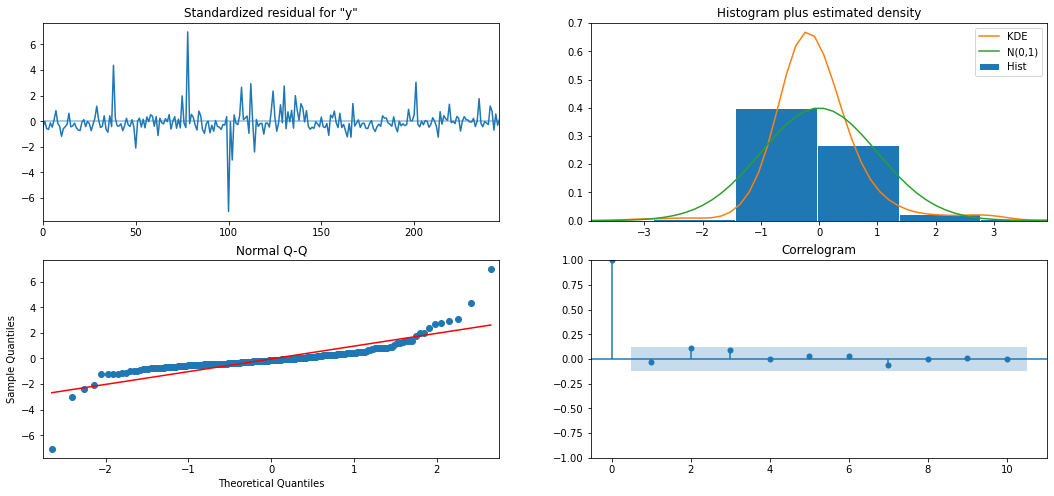

In [129]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Hence, we can tell that the residuals are uncorrelated and that they have zero mean. So the model is properly fitted.